In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
import NLsolve;
import Optim;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [1]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
mDsn-mDn-mπn

0.007033199999999962

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

In [4]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    return sol.zero[1] + im * sol.zero[2]
end

find_singular (generic function with 1 method)

In [5]:
qon_c(E)=find_singular(E, (E, p) -> E-mDc-mDsc - p^2 / (2 * μf(mDc, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDn-mDsn - p^2 / (2 * μf(mDn, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [6]:
qon_0(3.87165)|>println
qon_c(3.87165)|>println

0.002632213869851304 + 0.004723182681375603im
0.0008087602747414445 + 0.12618606917576505im


In [7]:
xxx,www=gauss(96,0,1);

qi=zeros(ComplexF64,2+length(xxx));
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

In [8]:
Γsmc(t,Λ,ω,V0)=t+im*V0*(1-exp(-t/ω))*(1-exp((t-Λ)/ω))
dΓsmc(t,Λ,ω,V0)=1+im*V0/ω*(exp(-t/ω)-exp((t-Λ)/ω))
Γsmcx(x,Λ,ω,V0)=Γsmc(Λ*x,Λ,ω,V0) #0~x~1
dΓsmcx(x,Λ,ω,V0)=Λ*dΓsmc(Λ*x,Λ,ω,V0)

dΓsmcx (generic function with 1 method)

# VGT

In [34]:
# function getqw(E,Λ;ω=0.1,V0=-0.1,qi=qi,wi=wi)
function getqw(E,Λ;ω=0.1,V0=-0.2,qi=qi,wi=wi)
    qi[1],qi[2]=qon_0(E),qon_c(E)
    for i in eachindex(xxx)
        qi[2+i]=Γsmcx(xxx[i],Λ,ω,V0)
        wi[i]=dΓsmcx(xxx[i],Λ,ω,V0)*www[i]
    end
    nothing
end

getqw (generic function with 1 method)

In [10]:
getqw(-2.9342589323633206e-5 - 1.2093054403108684e-5im,0.3)

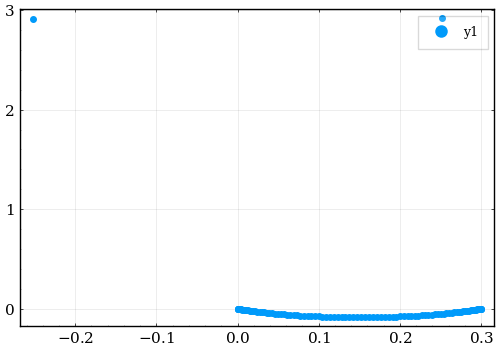

In [11]:
scatter(real.(qi[1:end]),imag.(qi[1:end]))

In [12]:
Vmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Gmat=zeros(ComplexF64,2*length(qi),2*length(qi));
Tmat=zeros(ComplexF64,2*length(qi),2*length(qi));

In [13]:
function VMat!(E;Λ=0.5,C=1,Cv = 0.0,Cp=0.0,isπ=true,plist=qi,des=Vmat)
    getqw(E,Λ)
    k1,k2=plist[1],plist[2]

    for l in eachindex(plist)
        for m in eachindex(plist)
            i, j = 1, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xn(E,plist[l], plist[m];C=C,Cv=Cv,Cp=Cp,isπ=isπ)
            i, j = 1, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xcross(E,plist[l], plist[m];C=C,Cv=Cv,Cp=Cp,isπ=isπ)
            i, j = 2, 1
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xcross(E,plist[l], plist[m]; C=C,Cv=Cv,Cp=Cp,isπ=isπ)
            i, j = 2, 2
            des[sublen*(i-1)+l, sublen*(j-1)+m] = potential_Xc(E,plist[l], plist[m];C=C,Cv=Cv,Cp=Cp,isπ=isπ)
        end
    end
    return nothing
end

VMat! (generic function with 1 method)

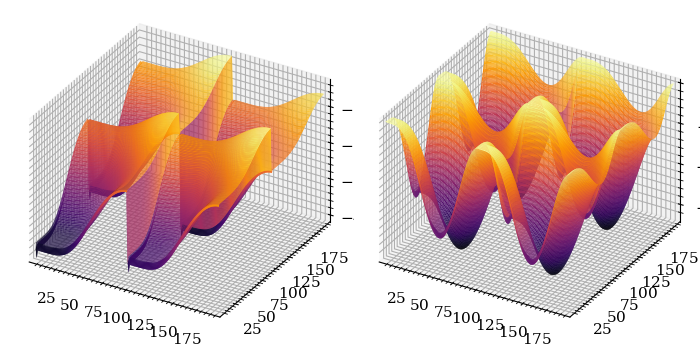

In [14]:
VMat!(3.87165,isπ=false)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

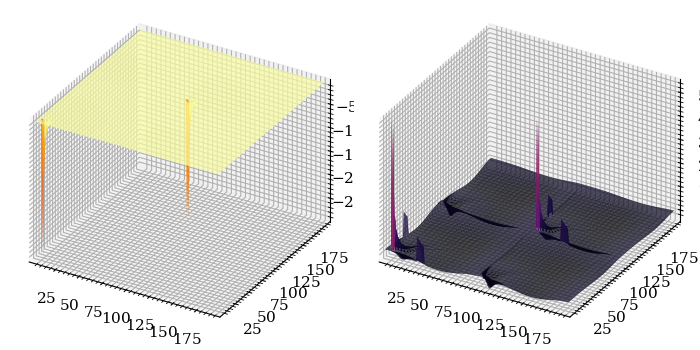

In [15]:
VMat!(3.87165,isπ=true)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

In [14]:
Gc(E,q)=1/(2π^2)/(E-mDc-mDsc-q^2/(2*μf(mDc,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDn-mDsn-q^2/(2*μf(mDn,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [15]:
function GMat!(E;Λ=0.5,qi=qi,wi=wi,des=Gmat)
    getqw(E,Λ)
    k1,k2=qi[1],qi[2]
    
    i=1
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gn(E,qi[2+j])
    end
    
    i=2
    for j in eachindex(wi)
        des[(i-1)*sublen+2+j,(i-1)*sublen+2+j]=wi[j]*qi[2+j]^2*Gc(E,qi[2+j])
    end
    
    return nothing
end

GMat! (generic function with 1 method)

In [16]:
function detVG(E;Λ=0.5,Cv = 0.0,Cp=0.0,C=1,isπ=true)
    VMat!(E;Λ=Λ,Cv=Cv,Cp=Cp,C=C,isπ=isπ)
    GMat!(E;Λ=Λ)
    return det(LinearAlgebra.I-Vmat*Gmat)
end

detVG (generic function with 1 method)

In [17]:
function TMat!(E;Λ=0.5,Cv = 0.0,Cp=0.0,C=1,des=Tmat,isπ=true)
    VMat!(E;Λ=Λ,Cv=Cv,Cp=Cp,C=C,isπ=isπ)
    GMat!(E;Λ=Λ)
    des .=inv(LinearAlgebra.I-Vmat*Gmat)*Vmat
    nothing
end

TMat! (generic function with 1 method)

In [20]:
@btime TMat!(3.87165)

  17.015 ms (2768 allocations: 2.61 MiB)


# Extract pole position

In [18]:
function find_poles(pars;C=1)
    _lam,_cv,_cp=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ;C=C, Λ = _lam,Cv=_cv,Cp=_cp,isπ=true)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsn - 40e-6, 0])
#     println((tmp.zero[1]-mDn-mDsn)+im*tmp.zero[2])
#     tmp
    return tmp.residual_norm <1e-8 ? (tmp.zero[1]-mDn-mDsn)+im*tmp.zero[2] : NaN+im*NaN
end

find_poles (generic function with 1 method)

In [19]:
function isplus(pars;C=1)
    _lam,_cv,_cp=pars 
    pole=find_poles([_lam,_cv,_cp];C=C)
    if isnan(pole)
        return 0
    end
    
    TMat!(mDn+mDsn+pole;Λ=_lam,Cv=_cv,Cp=_cp,C=C)
    v11=@view Vmat[1:sublen,1:sublen]
    v12=@view Vmat[1:sublen,1+sublen:2*sublen]
    g11=@view Gmat[1:sublen,1:sublen]
    g22=@view Gmat[1+sublen:2*sublen,1+sublen:2*sublen]
    tmp1,tmp2=det(LinearAlgebra.I-v11*g11-v12*g22),det(LinearAlgebra.I-v11*g11+v12*g22)
    return abs(tmp1)<abs(tmp2) ? 1 : -1
end

isplus (generic function with 1 method)

## C=+

In [20]:
find_poles([0.35,0.0,0.0])

-0.012138195792328776 + 4.12053502159461e-6im

In [30]:
find_poles([0.35,0.3,0.0])

-0.007384057603320393 - 4.027998416940637e-7im

In [35]:
find_poles([0.4,1.0,0.0])

-0.0010327811014034793 - 3.0229963678291e-5im

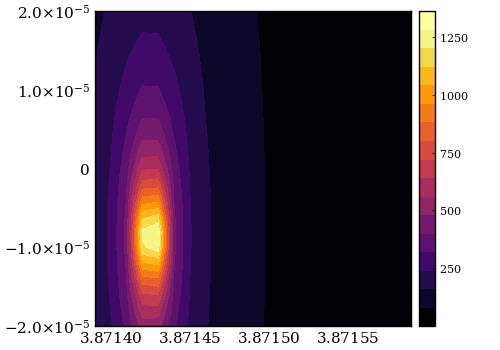

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [23]:
let Ev=collect(mDn+mDsn-300e-6:10e-6:mDn+mDsn-100e-6),Γv=collect(-20e-6:2e-6:20e-6)
    resv=[1/abs(detVG(e+im*γ;Λ=0.35,Cv=0.95)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

## C=-

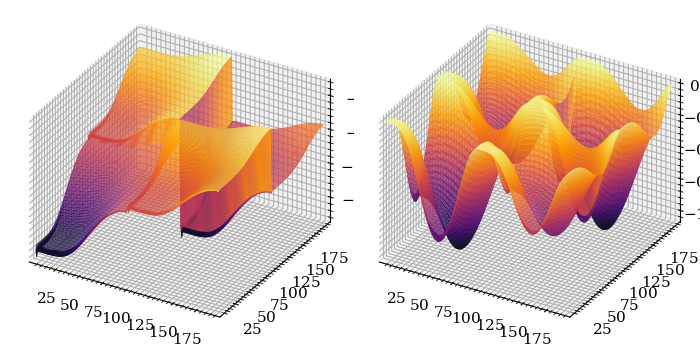

In [24]:
VMat!(3.87165;C=-1,isπ=false)
plot(surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[real(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),
surface(collect(1:2*length(qi)),collect(1:2*length(qi)),[imag(Vmat[x,y]) for y in 1:2*length(qi),x in 1:2*length(qi)],legend=false),layout=(1,2),size=(700,350))

In [27]:
find_poles([0.35,0.7,0.0];C=-1)

-0.00010231714020569882 - 1.3900776495653374e-5im

In [29]:
find_poles([0.4,0.8,0.0];C=-1)

-0.0036753535323121866 - 1.3609006370526519e-5im

In [30]:
find_poles([0.4,1.0,0.0];C=-1)

-0.0077336326944412725 - 1.5781682775943318e-5im

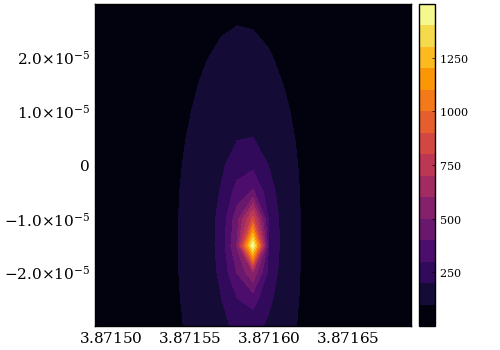

In [26]:
let Ev=collect(mDn+mDsn-200e-6:10e-6:mDn+mDsn),Γv=collect(-30e-6:5e-6:30e-6)
    resv=[1/abs(detVG(e+im*γ;C=-1,Λ=0.35,Cv=0.7,Cp=0.0)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

# load parameters from Tcc: Not working for meson-antimeson

In [18]:
using DataFrames,CSV;

In [21]:
df_paras=DataFrame(CSV.File("./output/heatmap_new.csv", header = ["Λ", "Cv","Cp"]));

In [22]:
function find_poles(pars;C=1)
    _lam,_cv,_cp=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ;C=C, Λ = _lam,Cv=_cv,Cp=_cp,isπ=true)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDsn - 40e-6, 0])
    return tmp.residual_norm < 1e-8 ? tmp.zero[1]+im*tmp.zero[2] : NaN+im*NaN
end

find_poles (generic function with 1 method)

## X(3872)

In [23]:
poles_x=[];

In [25]:
for i in 1:size(df_paras)[1]
    print(i," ")
    push!(poles_x,[[df_paras[i,1],df_paras[i,2],df_paras[i,3]],find_poles([df_paras[i,1],df_paras[i,2],df_paras[i,3]])])
end

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 

In [38]:
poles_x[70:81]

12-element Vector{Any}:
 Any[[1.1, 0.7, 0.05], NaN + NaN*im]
 Any[[1.1, 0.7, 0.1], NaN + NaN*im]
 Any[[1.1, 0.75, 0.65], NaN + NaN*im]
 Any[[1.1, 0.75, 0.7], NaN + NaN*im]
 Any[[1.15, 0.7, 0.05], NaN + NaN*im]
 Any[[1.15, 0.7, 0.1], NaN + NaN*im]
 Any[[1.15, 0.75, 0.65], NaN + NaN*im]
 Any[[1.15, 0.75, 0.7], NaN + NaN*im]
 Any[[1.2, 0.7, 0.05], NaN + NaN*im]
 Any[[1.2, 0.7, 0.1], NaN + NaN*im]
 Any[[1.2, 0.75, 0.65], NaN + NaN*im]
 Any[[1.2, 0.75, 0.7], NaN + NaN*im]

In [44]:
find_poles([0.35,0.9,0.0])

-0.0005170814819503988 - 7.3896554988517305e-6im


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8716500000000003, 0.0]
 * Zero: [3.8711729185180497, -7.3896554988517305e-6]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

In [45]:
find_poles([0.35,0.8,0.0])

-0.0012351397743723957 - 4.995624739103575e-6im


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.8716500000000003, 0.0]
 * Zero: [3.8704548602256277, -4.995624739103575e-6]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

# Parameter study

C=+

In [23]:
pyplot();

In [24]:
let Λv=collect(0.3:0.05:0.6),Cv_v=collect(0.7:0.02:1.0)
    global poles_CP=[find_poles([λ,c,0.0]) for c in Cv_v,λ in Λv]
end

16×7 Matrix{ComplexF64}:
 -0.000313055-2.1853e-5im    …    -0.027681+2.39972e-6im
 -0.000250294-2.21474e-5im       -0.0262597+2.09487e-6im
 -0.000194656-2.2225e-5im        -0.0248626+1.78542e-6im
 -0.000146476-2.20147e-5im       -0.0234903+1.30626e-6im
 -0.000106113-2.1424e-5im        -0.0221441+9.78835e-7im
  -7.39524e-5-2.0336e-5im    …   -0.0208247+5.48488e-7im
  -5.04262e-5-1.86096e-5im       -0.0195331+1.88336e-7im
          NaN+NaN*im             -0.0182704-5.78854e-7im
  -3.31112e-5-1.59865e-5im       -0.0170374-9.74691e-7im
          NaN+NaN*im             -0.0158354-1.39981e-6im
          NaN+NaN*im         …   -0.0146654-1.84787e-6im
          NaN+NaN*im             -0.0135285-2.33486e-6im
          NaN+NaN*im             -0.0124259-2.96872e-6im
  -5.12712e-5-0.000114113im      -0.0113589-3.53718e-6im
  -5.85439e-5-0.000156399im      -0.0103289-4.45889e-6im
  -7.64123e-5-0.000273986im  …  -0.00933669-5.3451e-6im

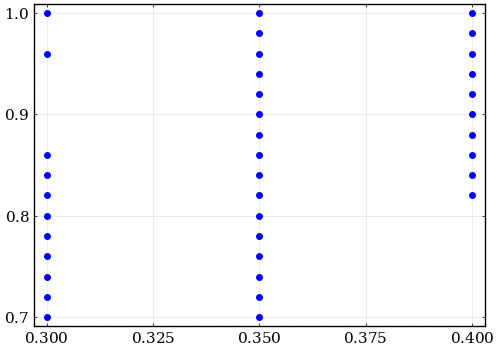

In [65]:
scatter(legend=false)
for i in 1:7,j in 1:16
    if !isnan(poles_CP[j,i])
        if isplus([0.3+0.05*(i-1),0.7+0.02*(j-1),0.0])==1
            scatter!([0.3+0.05*(i-1)],[0.7+0.02*(j-1)],color=:blue)
        else 
            scatter!([0.3+0.05*(i-1)],[0.7+0.02*(j-1)],color=:red)
        end
    end
end
current()

In [70]:
find_poles([0.3,1.0,0.0])|>println
find_poles([0.3,0.96,0.0])|>println
find_poles([0.3,0.86,0.0])|>println
find_poles([0.3,0.7,0.0])|>println
find_poles([0.35,1.0,0.0])|>println
find_poles([0.35,0.7,0.0])|>println
find_poles([0.4,1.0,0.0])|>println
find_poles([0.4,0.82,0.0])|>println

-9.973244451622065e-6 - 0.00015173673793898376im
-1.6621646153680558e-5 - 0.00011243783014627822im
-2.9342589323633206e-5 - 1.2093054403108684e-5im
-0.00030316734183655214 - 7.5952320169902e-6im
-9.742184384897712e-5 - 8.676639619657933e-6im
-0.0021806676217899224 - 3.088187535627051e-6im
-0.001021505482419638 - 6.922684004175148e-6im
-0.0034413684820022716 - 2.4076588274389097e-6im


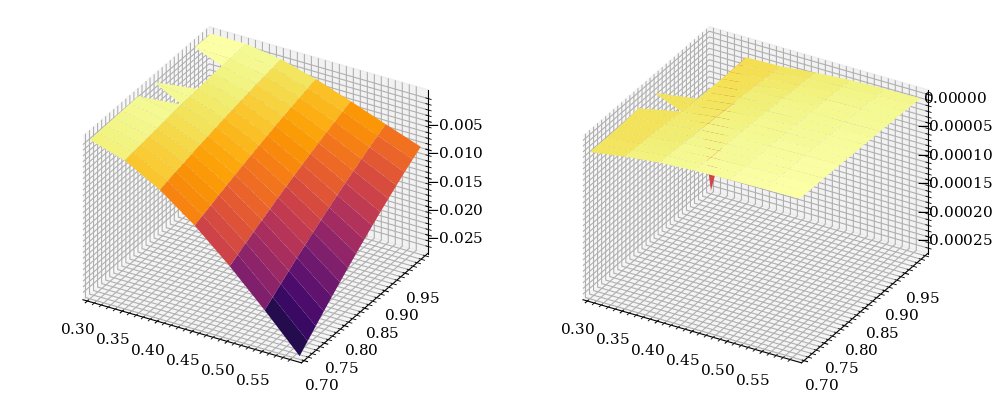

In [25]:
plot(surface(0.3:0.05:0.6,0.7:0.02:1.0,real.(poles_CP),legend=false),
    surface(0.3:0.05:0.6,0.7:0.02:1.0,imag.(poles_CP),legend=false),layout=(1,2),size=(1000,400))

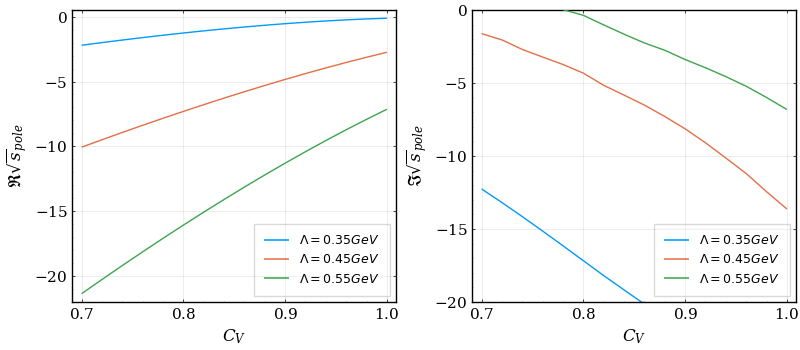

In [27]:
let 
    p1=plot(legend=:bottomright,xlabel=L"C_V",ylabel=L"\Re \sqrt{s}_{pole}")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CP)[2,:] .*1e3),label=L"\Lambda=0.35GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CP)[4,:] .*1e3),label=L"\Lambda=0.45GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CP)[6,:] .*1e3),label=L"\Lambda=0.55GeV")
    p2=plot(legend=:bottomright,xlabel=L"C_V",ylabel=L"\Im \sqrt{s}_{pole}",ylims=(-20,0))
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CP)[2,:] .*1e6),label=L"\Lambda=0.35GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CP)[4,:] .*1e6),label=L"\Lambda=0.45GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CP)[6,:] .*1e6),label=L"\Lambda=0.55GeV")
    plot(p1,p2,layout=(1,2),size=(800,350))
end

In [24]:
let Λv=collect(0.3:0.05:0.6),Cv_v=collect(0.7:0.02:1.0)
    global poles_CM=[find_poles([λ,c,0.0];C=-1) for c in Cv_v,λ in Λv]
end

16×7 Matrix{ComplexF64}:
   6.87574e-5-0.000500486im  …  -0.0339042-1.88308e-5im
   4.43337e-5-0.000406505im     -0.0356074-1.88706e-5im
   9.75687e-6-0.000258788im     -0.0373274-1.9092e-5im
   2.48668e-5-0.000323502im     -0.0390631-1.91291e-5im
    9.7346e-6-0.000254983im      -0.040814-1.92188e-5im
  -1.96818e-6-0.000197667im  …  -0.0425795-1.95036e-5im
  -1.09031e-5-0.000150498im     -0.0443588-1.96865e-5im
  -1.75647e-5-0.000112365im     -0.0461512-1.99134e-5im
  -2.27634e-5-8.22916e-5im      -0.0479563-2.0174e-5im
  -2.66773e-5-5.89833e-5im      -0.0497735-2.03805e-5im
  -2.98259e-5-4.14803e-5im   …  -0.0516023-2.06001e-5im
          NaN+NaN*im            -0.0534421-2.10541e-5im
  -5.30481e-5-1.83425e-5im      -0.0552927-2.12828e-5im
  -7.90422e-5-1.65206e-5im      -0.0571536-2.1485e-5im
 -0.000114341-1.49509e-5im      -0.0590242-2.20775e-5im
 -0.000158973-1.38098e-5im   …  -0.0609044-2.22535e-5im

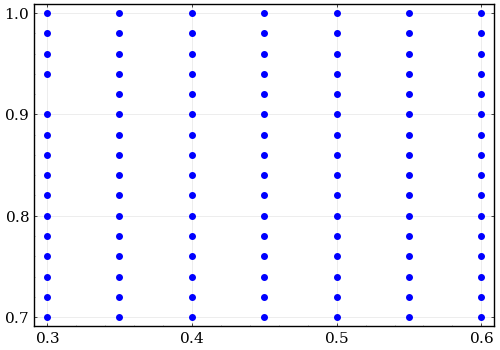

In [67]:
scatter(legend=false)
for i in 1:7,j in 1:16
    if !isnan(poles_CM[j,i])
        if isplus([0.3+0.05*(i-1),0.7+0.02*(j-1),0.0];C=-1)==1
            scatter!([0.3+0.05*(i-1)],[0.7+0.02*(j-1)],color=:blue)
        else 
            scatter!([0.3+0.05*(i-1)],[0.7+0.02*(j-1)],color=:red)
        end
    end
end
current()

In [71]:
find_poles([0.3,1.0,0.0];C=-1)|>println
find_poles([0.3,0.94,0.0];C=-1)|>println
find_poles([0.3,0.90,0.0];C=-1)|>println
find_poles([0.3,0.7,0.0];C=-1)|>println
find_poles([0.6,1.0,0.0];C=-1)|>println
find_poles([0.6,0.7,0.0];C=-1)|>println

-0.00015897308290879764 - 1.380976839057303e-5im
-5.3048094829755144e-5 - 1.8342537505154313e-5im
-2.982590713340727e-5 - 4.148032927258957e-5im
6.875735242939385e-5 - 0.0005004857444866993im
-0.060904387434950635 - 2.225352665314276e-5im
-0.03390417103873178 - 1.8830775139167457e-5im


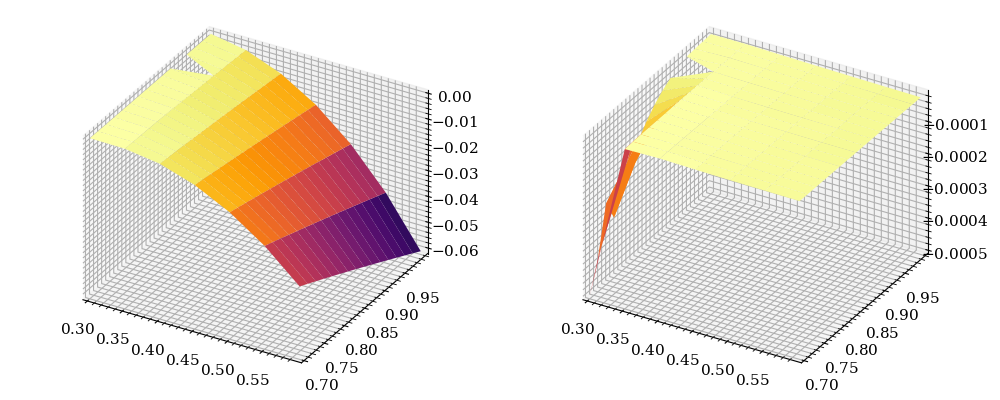

In [57]:
plot(surface(0.3:0.05:0.6,0.7:0.02:1.0,real.(poles_CM),legend=false),
    surface(0.3:0.05:0.6,0.7:0.02:1.0,imag.(poles_CM),legend=false),layout=(1,2),size=(1000,400))

In [118]:
mπn^2 -q0f(mDn+mDsn, mDn, mDsn, mDsn, mDn)^2|>println
mπc^2 -q0f(mDn+mDsn, mDn, mDsn, mDsc, mDc)^2|>println
mπn^2 -q0f(mDn+mDsn, mDc, mDsc, mDsc, mDc)^2|>println

-0.0019481035617600062
-0.0005362950386838955
-0.001647365781527601


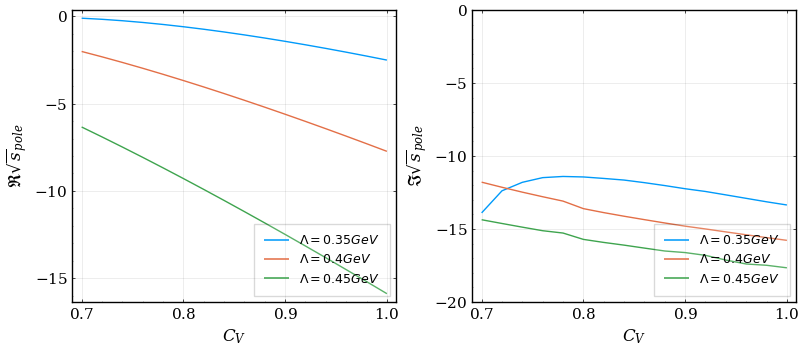

In [129]:
let 
    p1=plot(legend=:bottomright,xlabel=L"C_V",ylabel=L"\Re \sqrt{s}_{pole}")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CM)[2,:] .*1e3),label=L"\Lambda=0.35GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CM)[3,:] .*1e3),label=L"\Lambda=0.4GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CM)[4,:] .*1e3),label=L"\Lambda=0.45GeV")
    p2=plot(legend=:bottomright,xlabel=L"C_V",ylabel=L"\Im \sqrt{s}_{pole}",ylims=(-20,0))
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CM)[2,:] .*1e6),label=L"\Lambda=0.35GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CM)[3,:] .*1e6),label=L"\Lambda=0.4GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CM)[4,:] .*1e6),label=L"\Lambda=0.45GeV")
    plot(p1,p2,layout=(1,2),size=(800,350))
end

# Parameter study more wide

In [36]:
let Λv=collect(0.3:0.05:0.7),Cv_v=collect(0.5:0.02:1.0)
    global poles_CP1=[find_poles([λ,c,0.0]) for c in Cv_v,λ in Λv]
end

26×9 Matrix{ComplexF64}:
  -0.00127033-2.69656e-5im   …  -0.0643358+5.36104e-6im
  -0.00115143-2.72511e-5im       -0.061779+4.74044e-6im
  -0.00103705-2.75099e-5im      -0.0592538+4.56021e-6im
 -0.000927408-2.77379e-5im      -0.0567604+3.56436e-6im
 -0.000822718-2.79299e-5im      -0.0543011+2.19407e-6im
 -0.000723218-2.80793e-5im   …  -0.0518766+1.22756e-6im
 -0.000629153-2.81771e-5im      -0.0494884+5.0476e-7im
  -0.00054078-2.82115e-5im      -0.0471378-2.79742e-7im
 -0.000458368-2.81668e-5im      -0.0448263-1.74642e-6im
 -0.000382197-2.8022e-5im        -0.042555-2.59209e-6im
 -0.000312558-2.77484e-5im   …  -0.0403255-3.4574e-6im
 -0.000249754-2.73076e-5im      -0.0381391-4.31387e-6im
 -0.000194101-2.66475e-5im      -0.0359977-5.63562e-6im
 -0.000145931-2.5698e-5im       -0.0339021-7.09211e-6im
 -0.000105598-2.4366e-5im       -0.0318542-8.0854e-6im
   -7.3496e-5-2.25444e-5im   …  -0.0298558-9.15127e-6im
  -4.98105e-5-2.02756e-5im      -0.0279081-1.0269e-5im
          NaN+NaN*im       

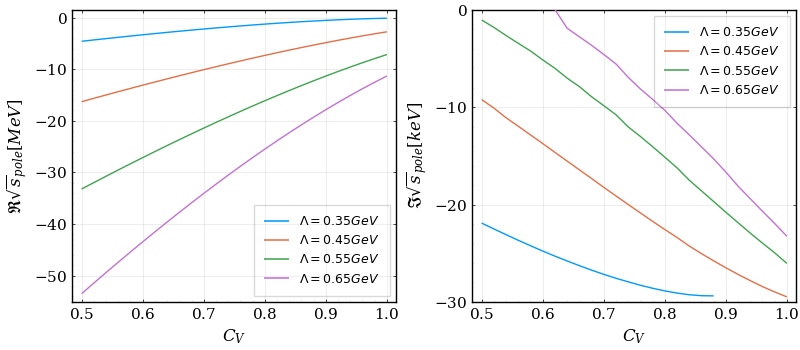

In [47]:
let 
    p1=plot(legend=:bottomright,xlabel=L"C_V",ylabel=L"\Re \sqrt{s}_{pole}[MeV]")
    plot!(0.5:0.02:1.0,real.(transpose(poles_CP1)[2,:] .*1e3),label=L"\Lambda=0.35GeV")
    plot!(0.5:0.02:1.0,real.(transpose(poles_CP1)[4,:] .*1e3),label=L"\Lambda=0.45GeV")
    plot!(0.5:0.02:1.0,real.(transpose(poles_CP1)[6,:] .*1e3),label=L"\Lambda=0.55GeV")
    plot!(0.5:0.02:1.0,real.(transpose(poles_CP1)[8,:] .*1e3),label=L"\Lambda=0.65GeV")
    p2=plot(legend=:topright,xlabel=L"C_V",ylabel=L"\Im \sqrt{s}_{pole}[keV]",ylims=(-30,0))
    plot!(collect(0.5:0.02:1.0)[1:20],imag.(transpose(poles_CP1)[2,1:20] .*1e6),label=L"\Lambda=0.35GeV")
    plot!(0.5:0.02:1.0,imag.(transpose(poles_CP1)[4,:] .*1e6),label=L"\Lambda=0.45GeV")
    plot!(0.5:0.02:1.0,imag.(transpose(poles_CP1)[6,:] .*1e6),label=L"\Lambda=0.55GeV")
    plot!(collect(0.5:0.02:1.0),imag.(transpose(poles_CP1)[8,:] .*1e6),label=L"\Lambda=0.65GeV")
    plot(p1,p2,layout=(1,2),size=(800,350))
end

# get data plotting

In [79]:
function getqw(E,Λ;ω=0.1,V0=-0.12,qi=qi,wi=wi)
    qi[1],qi[2]=qon_0(E),qon_c(E)
    for i in eachindex(xxx)
        qi[2+i]=Γsmcx(xxx[i],Λ,ω,V0)
        wi[i]=dΓsmcx(xxx[i],Λ,ω,V0)*www[i]
    end
    nothing
end

getqw (generic function with 1 method)

In [102]:
# gr(frame=:box, minorticks=5, size=(500,350), fontfamily="sans-serif",titlefontsize=11
#     ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
#     bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto,foreground_color_legend = nothing);
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="sans-serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [80]:
let Λv=collect(0.35:0.025:0.45),Cv_v=collect(0.7:0.02:1.0)
    global poles_CP1=[find_poles([λ,c,0.0]) for c in Cv_v,λ in Λv]
end

16×5 Matrix{ComplexF64}:
   -0.0021868-6.3498e-6im   …   -0.0100645-1.06485e-7im
  -0.00198251-6.86931e-6im     -0.00949093-4.418e-7im
  -0.00178552-7.42495e-6im      -0.0089273-7.35508e-7im
  -0.00159625-8.02627e-6im     -0.00837379-1.19817e-6im
   -0.0014151-8.6849e-6im      -0.00783105-1.56615e-6im
  -0.00124256-9.38542e-6im  …  -0.00729949-1.94712e-6im
  -0.00107905-1.02044e-5im     -0.00677969-2.29615e-6im
 -0.000925088-1.11259e-5im     -0.00627205-2.70988e-6im
 -0.000781197-1.21612e-5im     -0.00577748-3.24099e-6im
 -0.000647918-1.3311e-5im      -0.00529615-3.66725e-6im
 -0.000525813-1.45551e-5im  …  -0.00482886-4.16347e-6im
 -0.000415479-1.58409e-5im     -0.00437633-4.8329e-6im
 -0.000317517-1.70837e-5im     -0.00393945-5.38099e-6im
 -0.000232604-1.81471e-5im     -0.00351902-6.02166e-6im
 -0.000161453-1.88478e-5im     -0.00311603-6.61159e-6im
 -0.000104843-1.89439e-5im  …  -0.00273136-7.28802e-6im

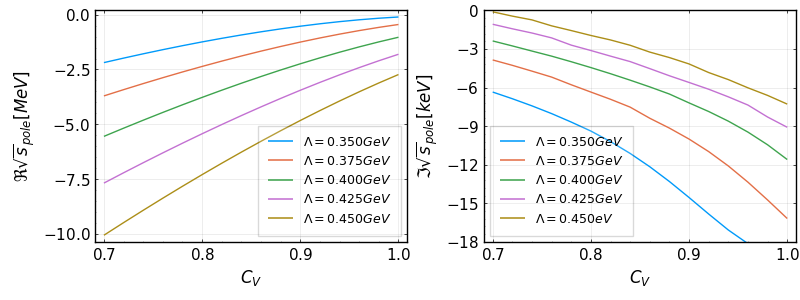

In [103]:
let 
    p1=plot(legend=:bottomright,xlabel=L"C_V",ylabel=L"\Re \sqrt{s}_{pole}[MeV]",left_margin = 3Plots.mm,bottom_margin = 3Plots.mm)
    plot!(0.7:0.02:1.0,real.(transpose(poles_CP1)[1,:] .*1e3),label=L"\Lambda=0.350GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CP1)[2,:] .*1e3),label=L"\Lambda=0.375GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CP1)[3,:] .*1e3),label=L"\Lambda=0.400GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CP1)[4,:] .*1e3),label=L"\Lambda=0.425GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CP1)[5,:] .*1e3),label=L"\Lambda=0.450GeV")
    p2=plot(legend=:bottomleft,xlabel=L"C_V",ylabel=L"\Im \sqrt{s}_{pole}[keV]",ylims=(-18,0))
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CP1)[1,:] .*1e6),label=L"\Lambda=0.350GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CP1)[2,:] .*1e6),label=L"\Lambda=0.375GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CP1)[3,:] .*1e6),label=L"\Lambda=0.400GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CP1)[4,:] .*1e6),label=L"\Lambda=0.425GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CP1)[5,:] .*1e6),label=L"\Lambda=0.450eV")
    plot(p1,p2,layout=(1,2),size=(800,300))
#     savefig("./images/poles_ccbar_plus.pdf")
end

In [88]:
let Λv=collect(0.35:0.05:0.55),Cv_v=collect(0.7:0.02:1.0)
    global poles_CM1=[find_poles([λ,c,0.0];C=-1) for c in Cv_v,λ in Λv]
end

16×5 Matrix{ComplexF64}:
  -9.51214e-5-3.96894e-6im  …  -0.0221182-1.66721e-5im
   -0.0001573-2.95009e-6im     -0.0233673-1.69338e-5im
 -0.000238538-2.87334e-6im     -0.0246308-1.72218e-5im
 -0.000337459-3.36394e-6im     -0.0259082-1.74922e-5im
 -0.000452708-4.14184e-6im     -0.0271988-1.76547e-5im
 -0.000583001-5.01047e-6im  …   -0.028502-1.79758e-5im
 -0.000727104-5.86299e-6im      -0.029817-1.8247e-5im
 -0.000883926-6.64138e-6im     -0.0311435-1.83292e-5im
  -0.00105248-7.33208e-6im     -0.0324809-1.85978e-5im
  -0.00123188-7.94254e-6im     -0.0338288-1.8836e-5im
  -0.00142136-8.45268e-6im  …  -0.0351867-1.91835e-5im
  -0.00162018-8.94376e-6im     -0.0365544-1.92748e-5im
  -0.00182774-9.39497e-6im      -0.037931-1.95448e-5im
  -0.00204345-9.81422e-6im     -0.0393167-1.99167e-5im
   -0.0022668-1.02065e-5im     -0.0407107-2.02024e-5im
  -0.00249735-1.05659e-5im  …   -0.042113-2.02739e-5im

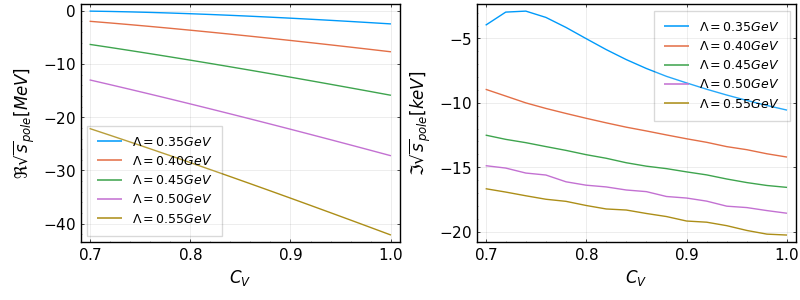

In [104]:
let 
    p1=plot(legend=:bottomleft,xlabel=L"C_V",ylabel=L"\Re \sqrt{s}_{pole}[MeV]",left_margin = 3Plots.mm,bottom_margin = 3Plots.mm)
    plot!(0.7:0.02:1.0,real.(transpose(poles_CM1)[1,:] .*1e3),label=L"\Lambda=0.35GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CM1)[2,:] .*1e3),label=L"\Lambda=0.40GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CM1)[3,:] .*1e3),label=L"\Lambda=0.45GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CM1)[4,:] .*1e3),label=L"\Lambda=0.50GeV")
    plot!(0.7:0.02:1.0,real.(transpose(poles_CM1)[5,:] .*1e3),label=L"\Lambda=0.55GeV")
    p2=plot(legend=:topright,xlabel=L"C_V",ylabel=L"\Im \sqrt{s}_{pole}[keV]")#,ylims=(-20,0))
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CM1)[1,:] .*1e6),label=L"\Lambda=0.35GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CM1)[2,:] .*1e6),label=L"\Lambda=0.40GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CM1)[3,:] .*1e6),label=L"\Lambda=0.45GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CM1)[4,:] .*1e6),label=L"\Lambda=0.50GeV")
    plot!(0.7:0.02:1.0,imag.(transpose(poles_CM1)[5,:] .*1e6),label=L"\Lambda=0.55GeV")
    plot(p1,p2,layout=(1,2),size=(800,300))
#     savefig("./images/poles_ccbar_minus.pdf")
end